In [1]:
import numpy as np

def cov_fn_se(x_1, x_2,alpha, rho,jit):
    tmp = -0.5*((x_1-x_2)/rho)**2 
    if x_1 == x_2:
        tmp += jit
    return (alpha**2)*np.exp(tmp)
def cov_fn_per(x_1, x_2,alpha, rho, period):
    tmp = np.abs((x_1-x_2)/period)
    tmp = -2*np.sin(tmp)*np.sin(tmp)/(rho**2)
    return (alpha**2)*np.exp(tmp)

In [2]:
#create grid for prediction, and random inputs
x = np.arange(500)*0.01
x_inds = np.random.choice(len(x),10,replace=True)
x_inds = np.sort(x_inds)
x_obs = x[x_inds]
x_obs

array([ 0.56,  0.62,  0.7 ,  1.08,  1.42,  1.46,  1.55,  1.84,  3.25,  4.76])

In [3]:
#build the necessary covariance matrices
jit = 0.00001
alpha = 5.
ls = 1.

K_all = np.array([[cov_fn_se(x[i],x[j],alpha,ls,jit) for i in range(len(x))] for j in range(len(x))])
K_obs = K_all[x_inds,:]
K_obs = K_obs[:,x_inds]
invK_obs = np.linalg.inv(K_obs)

star_inds = [i for i in range(len(x)) if not np.any(x_obs==x[i]) ]
K_starstar = K_all[star_inds,:]
K_starstar = K_starstar[:,star_inds]
K_star = K_all[star_inds, :]
K_star = K_star[:,x_inds]

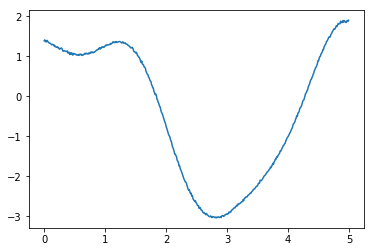

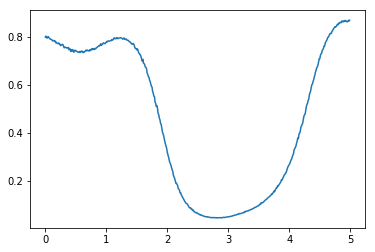

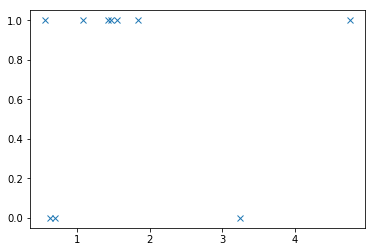

In [4]:
#sample a latent function, transform to probabilities, sample y 
#(might have to repeat a couple of times to get pretty data)
import matplotlib.pyplot as plt
f = np.random.multivariate_normal(np.zeros(len(x)),K_all)
fp = 1./(1+np.exp(-f))
plt.plot(x,f)
plt.show()

plt.plot(x,fp)
plt.show()

y_obs = (np.random.rand(len(x_inds))<fp[x_inds]).astype(int)
plt.plot(x_obs,y_obs,'x')
plt.show()


In [5]:
#functions to return hessian, log lik, etc
def loglik(f,y,invK, neg = True):
    gauss_part = -0.5*np.dot(f.T,np.dot(invK,f)) #ignore normalizing constants
    lik_part = -np.log(1+np.exp((2*y-1)*f))
    ll = gauss_part+np.sum(lik_part)
    if neg:
        ll = -ll
    return ll

def loglik_g(f,y,invK,neg=True):
    prob = 1./(1+np.exp(-f))
    gauss_part = -np.dot(invK,f)
    lik_part = y-prob
    grad = lik_part + gauss_part
    if neg:
        grad = -grad
    return grad

def loglik_H(f,y,invK):
    gauss_part = -invK
    prob = 1./(1+np.exp(-f))
    lik_part = np.diag(prob*(1-prob))
    H = gauss_part - lik_part
    return H, lik_part

In [7]:
#initialize to y
f0 = y_obs+0
from scipy.optimize import minimize
print('initial log likelihood: ',loglik(f0,y_obs,invK_obs))
f = minimize(loglik,f0,method='BFGS',jac=loglik_g,args=(y_obs,invK_obs),options={'disp': True})
loglik(f.x,y_obs,invK_obs)

initial log likelihood:  597.949420557
         Current function value: 10.508134
         Iterations: 4
         Function evaluations: 88
         Gradient evaluations: 76


10.508134273179053

In [9]:
#calculate hessian and therefore covariance
hess, W = loglik_H(f.x,y_obs,invK_obs)
cov_obs = np.linalg.inv(-1*hess)

In [10]:
#calculate mean
mean = np.dot(K_star,np.dot(invK_obs,f.x))

In [11]:
#calculate predictive covariance... see 3.23-3.25 in GP book 
tmp = np.linalg.inv(K_obs + np.linalg.inv(W))
cov_full = K_starstar - np.dot(K_star,np.dot(tmp,K_star.T))


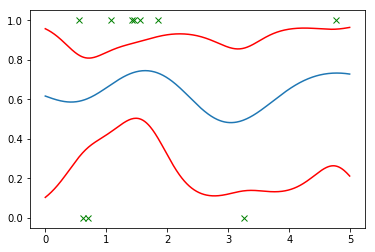

In [15]:
#plot with 1sd
plt.plot(x[star_inds],1./(1+np.exp(-mean)))
plt.plot(x[star_inds],1./(1+np.exp(-mean-np.sqrt(np.diag(cov_full)))),'r-')
plt.plot(x[star_inds],1./(1+np.exp(-mean+np.sqrt(np.diag(cov_full)))),'r-')
plt.plot(x[x_inds],y_obs,'gx')
plt.show()

